# Gaussian Mixture Model

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from sklearn import mixture
from sklearn import preprocessing
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import feature_extraction as fe
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
client = mongo_client.CERNMongoClient()
df = client.query_resample("^MKI.(A|B).*B1:.*", '1T', comp_val='2016-04-016 00:00:00.000000')
df_elogbook = client.query_resample("MKI.ELOGBOOK", None, "$gte", "16-04-23 06:00:00.000000")
# marker column is to plot it together with other data
df_elogbook['marker'] = 0

Fetching data for pattern ^MKI.(A|B).*B1:.*
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN
Fetching data for pattern MKI.ELOGBOOK
Fetching data for MKI.ELOGBOOK


## Feature extraction

In [81]:
df = ad_pp.filter_extremes(df)

Noticed during feature building: data between 2016-05-02 10:11:00 and 10:27:00 is missing

In [84]:
display(df['2016-5-2 10:10':'2016-5-2 10:30'])
display(df_elogbook['2016-5-2':'2016-5-3'])
df_elogbook.loc['2016-05-02 12:59:00', "MKI.ELOGBOOK"][0]

series               MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
timestamps                                                              
2016-05-02 10:10:00                        20.7          7.950000e-11   
2016-05-02 10:11:00                        20.7          7.966667e-11   
2016-05-02 10:27:00                        20.7          8.050000e-11   
2016-05-02 10:28:00                        20.7          8.050000e-11   
2016-05-02 10:29:00                        20.7          8.050000e-11   
2016-05-02 10:30:00                        20.7          7.450000e-11   

series               MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                                    
2016-05-02 10:10:00                        20.7                        21.8   
2016-05-02 10:11:00                        20.7                        21.8   
2016-05-02 10:27:00                        20.7                        21.8   
2016-05-02 10:28:00                        20.7                        21.8   
2016-05-02 10:29:00                        20.7                        21.8   
2016-05-02 10:30:00                        20.7                        21.8   

series               MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
timestamps                                                                    
2016-05-02 10:10:00                          20.5                      20.7   
2016-05-02 10:11:00                          20.5                      20.7   
2016-05-02 10:27:00                          20.5                      20.7   
2016-05-02 10:28:00                          20.5                      20.7   
2016-05-02 10:29:00                          20.5                      20.7   
2016-05-02 10:30:00                          20.5                      20.7   

series               MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
timestamps                                                                  
2016-05-02 10:10:00                      20.7                        19.8   
2016-05-02 10:11:00                      20.7                        19.8   
2016-05-02 10:27:00                      20.7                        19.8   
2016-05-02 10:28:00                      20.7                        19.8   
2016-05-02 10:29:00                      20.7                        19.8   
2016-05-02 10:30:00                      20.7                        19.8   

series               MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  
timestamps                                                               
2016-05-02 10:10:00          2.600000e-11                          22.1  
2016-05-02 10:11:00          2.600000e-11                          22.1  
2016-05-02 10:27:00          2.500000e-11                          22.1  
2016-05-02 10:28:00          2.500000e-11                          22.1  
2016-05-02 10:29:00          2.500000e-11                          22.1  
2016-05-02 10:30:00          2.500000e-11                          22.1

series                                                    MKI.ELOGBOOK  marker
timestamps                                                                    
2016-05-02 10:00:00  {u'USERNAME': u'roger.andrew.barlow@cern.ch', ...       0
2016-05-02 12:59:00  {u'USERNAME': u'roger.andrew.barlow@cern.ch', ...       0
2016-05-03 06:30:00  {u'USERNAME': u'mike.barnes@cern.ch', u'EVENT_...       0
2016-05-03 08:50:00  {u'USERNAME': u'roger.andrew.barlow@cern.ch', ...       0

{u'C0': u'9',
 u'EVENTDATE': u'02/05/2016 14:59:00',
 u'EVENT_ID': u'2104506',
 u'PATH': u'LHC.MKI8',
 u'SUBSTR_COMMENT_512_': u"Stopped the MKI8 today around 12.00 am to 'burn' the EPROM to ensure the latest modifications (specifically to the INJECTION_PERMIT) are now inside the PLC. \n\nPut SYSTEM back in STANDBY (with correct masks applied where required). \n\nALL good.",
 u'TAG': u'KEY',
 u'USERNAME': u'roger.andrew.barlow@cern.ch',
 u'VALUE': u'MKI8'}

In [49]:
new_index = pd.date_range(start=df.index[0], end=df.index[-1], freq='1T')
df = df.reindex(new_index, method='bfill')

In [50]:
# create features: sliding window mean, diff and sum
# 10 min windows
SWM_T10 = fe.sliding_window_mean(df, "T", 10)
SWMD_T10 = fe.sliding_window_mean_diff(df, "T", 10)
SWS_T10 = fe.sliding_window_sum(df, "T", 10)
features = pd.concat([df, SWM_T10, SWMD_T10, SWS_T10], axis=1)

In [51]:
dfs = ad_pp.scale_robust(features)
dfs.describe()

series  MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.B5L2.B1:PRESSURE  \
count                230400.000000         230400.000000   
mean                      0.056314              0.548747   
std                       0.513917              1.140132   
min                      -0.576471             -0.424125   
25%                      -0.458824             -0.163424   
50%                       0.000000              0.000000   
75%                       0.541176              0.836576   
max                       1.088235             31.368538   

series  MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
count                230400.000000               230400.000000   
mean                      0.155448                    0.162330   
std                       0.514958                    0.507259   
min                      -0.436620                   -0.429412   
25%                      -0.338028                   -0.323529   
50%                       0.000000                    0.000000   
75%                       0.661972                    0.676471   
max                       1.225352                    1.223529   

series  MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
count                  230400.000000             230400.000000   
mean                        0.019637                  0.111935   
std                         0.508876                  0.671550   
min                        -0.659341                 -0.607656   
25%                        -0.494505                 -0.502392   
50%                         0.000000                  0.000000   
75%                         0.505495                  0.497608   
max                         0.934066                  2.526316   

series  MKI.A5L2.B1:TEMP_TUBE_UP  MKI.B5L2.B1:TEMP_MAGNET_UP  \
count              230400.000000               230400.000000   
mean                    0.184220                    0.044461   
std                     0.507964                    0.512381   
min                    -0.352227                   -0.591195   
25%                    -0.301619                   -0.465409   
50%                     0.000000                    0.000000   
75%                     0.698381                    0.534591   
max                     1.307692                    1.062893   

series  MKI.A5L2.B1:PRESSURE  MKI.A5L2.B1:TEMP_MAGNET_DOWN  \
count          230400.000000                 230400.000000   
mean                0.404805                      0.033281   
std                 0.888802                      0.505159   
min                -0.470588                     -0.616822   
25%                -0.176471                     -0.476636   
50%                 0.000000                      0.000000   
75%                 0.823529                      0.523364   
max                57.995588                      0.971963   

series                   ...                     \
count                    ...                      
mean                     ...                      
std                      ...                      
min                      ...                      
25%                      ...                      
50%                      ...                      
75%                      ...                      
max                      ...                      

series  MKI.A5L2.B1:TEMP_MAGNET_UP:SW_SUM_T10  \
count                           230400.000000   
mean                                 0.056290   
std                                  0.513961   
min                                 -1.670588   
25%                                 -0.458824   
50%                                  0.000000   
75%                                  0.541176   
max                                  1.088235   

series  MKI.B5L2.B1:PRESSURE:SW_SUM_T10  \
count                     230400.000000   
mean                           0.547502   
std                            1.131451   
min                           -0.662560   
25%             

## GMM

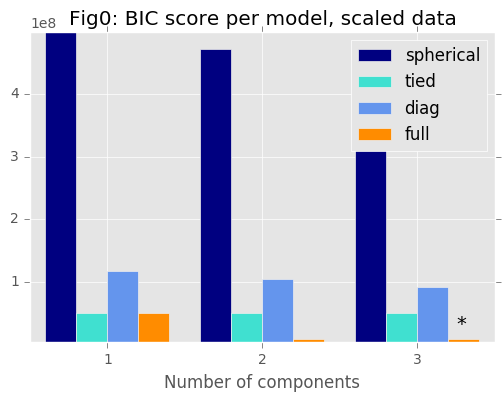

In [53]:
GMM.component_selection(dfs, 'Fig0: BIC score per model, scaled data', 3)

3 components, trying above 3 gives:

ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

In [64]:
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

## Anomaly Detection

'Log probs shape: 230400'

'Log probs mean: -19.6097127848'

'Log probs min: -25000.0873703'

'Log probs max: 17.0930647021'

'1pct percentile: -124'

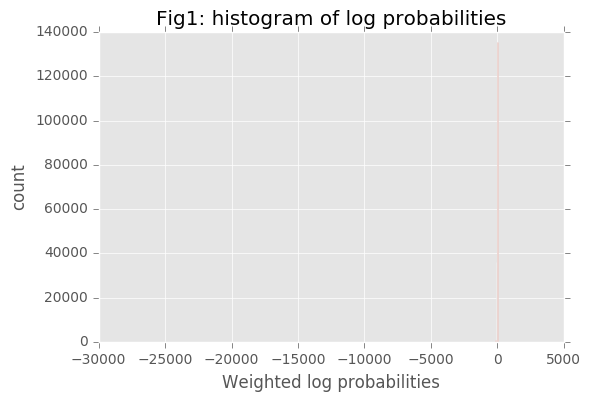

In [65]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.score_samples(dfs)
display("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]
binwidth = 15
plt.figure()
plt.hist(log_probs, bins=np.arange(min(log_probs), max(log_probs) + binwidth, binwidth));
plt.title("Fig1: histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

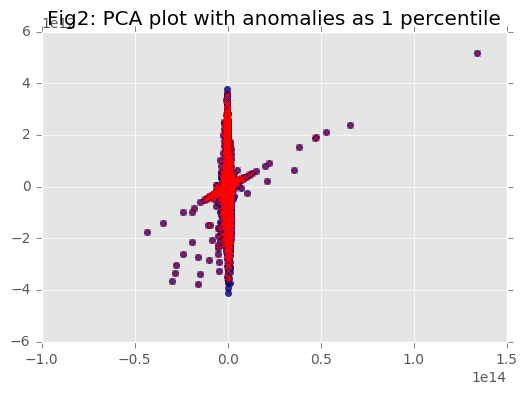

In [66]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(dfs, pca)
PCA.plot_anomalies(pca_data, idx[0], "Fig2: PCA plot with anomalies as 1 percentile")

1 percentile data is too much for anomalies, but already shows how they are spread out. All but 1 outliers in PCA are detected.

In [101]:
display(pca.components_)
component1 = pca.components_[0]
# select components with most variance
c_idx = list(np.where((abs(component1) > 1e-4))[0])
display(c_idx)
display(np.array(dfs.columns.values)[c_idx])

array([[ -3.20101070e-15,   2.32104158e-14,  -3.02249549e-14,
         -3.33133616e-14,  -2.91439506e-15,   4.27101492e-15,
         -3.00185208e-14,  -3.49458485e-15,   3.09373306e-13,
         -2.68274136e-15,  -3.09102103e-15,  -2.95183081e-14,
         -2.99417169e-14,  -3.34387731e-14,  -2.73884510e-15,
          6.00821322e-15,  -3.00737429e-14,  -3.34582548e-15,
         -4.46945073e-14,  -2.56203607e-15,  -2.92708467e-02,
          3.47550212e-12,  -4.60240099e-03,   1.78605246e-03,
         -1.49886804e-02,  -1.75883058e-02,   1.36398417e-13,
         -1.90218701e-02,   9.99046517e-01,  -1.13605636e-02,
         -3.09102110e-15,  -2.95183081e-14,  -2.99417170e-14,
         -3.34387732e-14,  -2.73884523e-15,   6.00821316e-15,
         -3.00737429e-14,  -3.34582555e-15,  -4.46945073e-14,
         -2.56203620e-15],
       [  4.03656652e-15,   3.90647859e-13,   2.40073155e-13,
          2.48359823e-13,  -7.97870328e-15,   8.39663739e-14,
          2.57518264e-13,   7.36967838e-15,

[20, 22, 23, 24, 25, 27, 28, 29]

array([u'MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_T10',
       u'MKI.B5L2.B1:TEMP_TUBE_DOWN:SW_MEAN_DIFF_T10',
       u'MKI.A5L2.B1:TEMP_TUBE_DOWN:SW_MEAN_DIFF_T10',
       u'MKI.B5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_T10',
       u'MKI.B5L2.B1:TEMP_TUBE_UP:SW_MEAN_DIFF_T10',
       u'MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_T10',
       u'MKI.A5L2.B1:PRESSURE:SW_MEAN_DIFF_T10',
       u'MKI.A5L2.B1:TEMP_MAGNET_DOWN:SW_MEAN_DIFF_T10'], dtype=object)

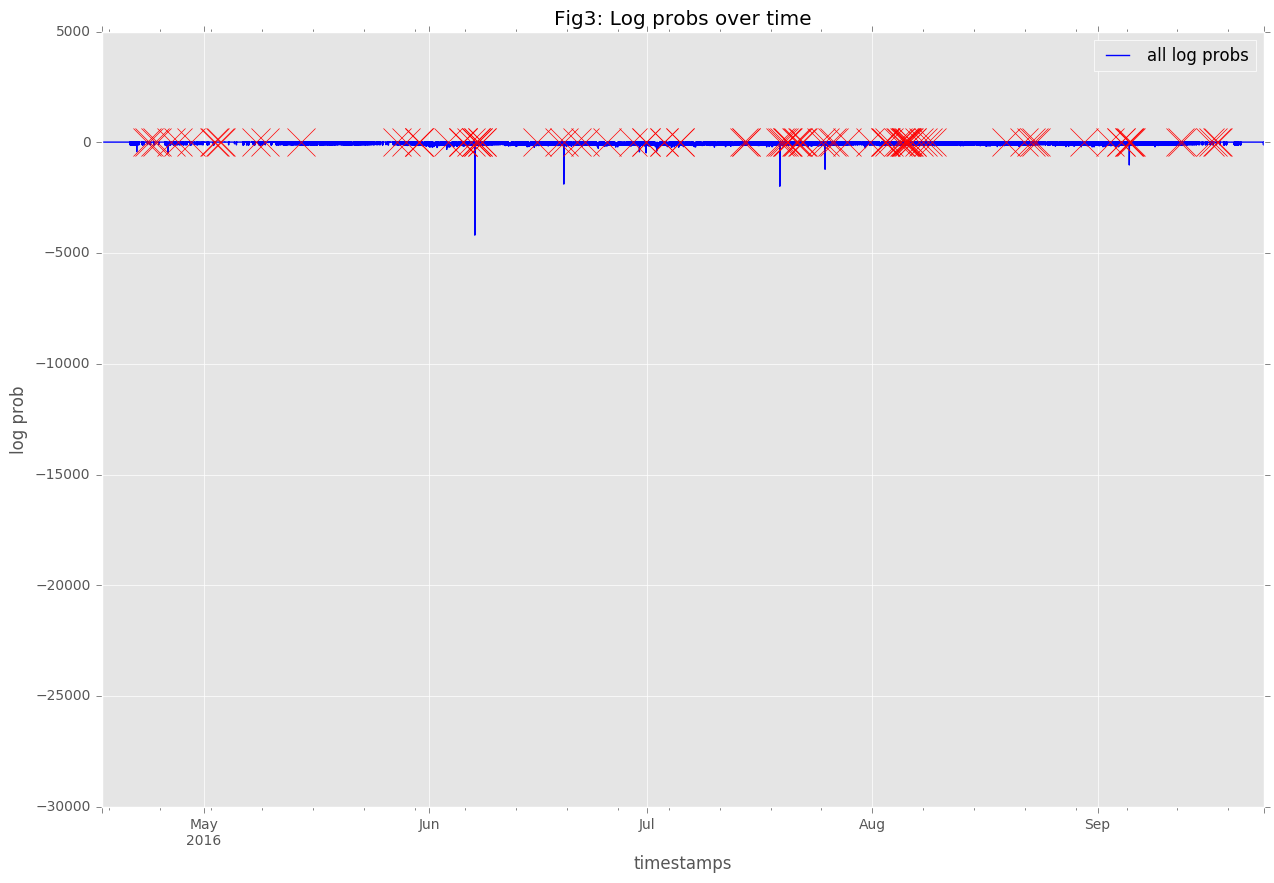

In [67]:
log_probs_df = pd.DataFrame(data=log_probs, index=dfs.index)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df.plot(ax=axes, color='b')
df_elogbook.plot(ax=axes, y='marker', linestyle='none', marker='x', markersize=20, color='red')
labels = ["all log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig3: Log probs over time")

Plot shows how the log probabilities change over time. All red X'es mark an event in the e-logbook.

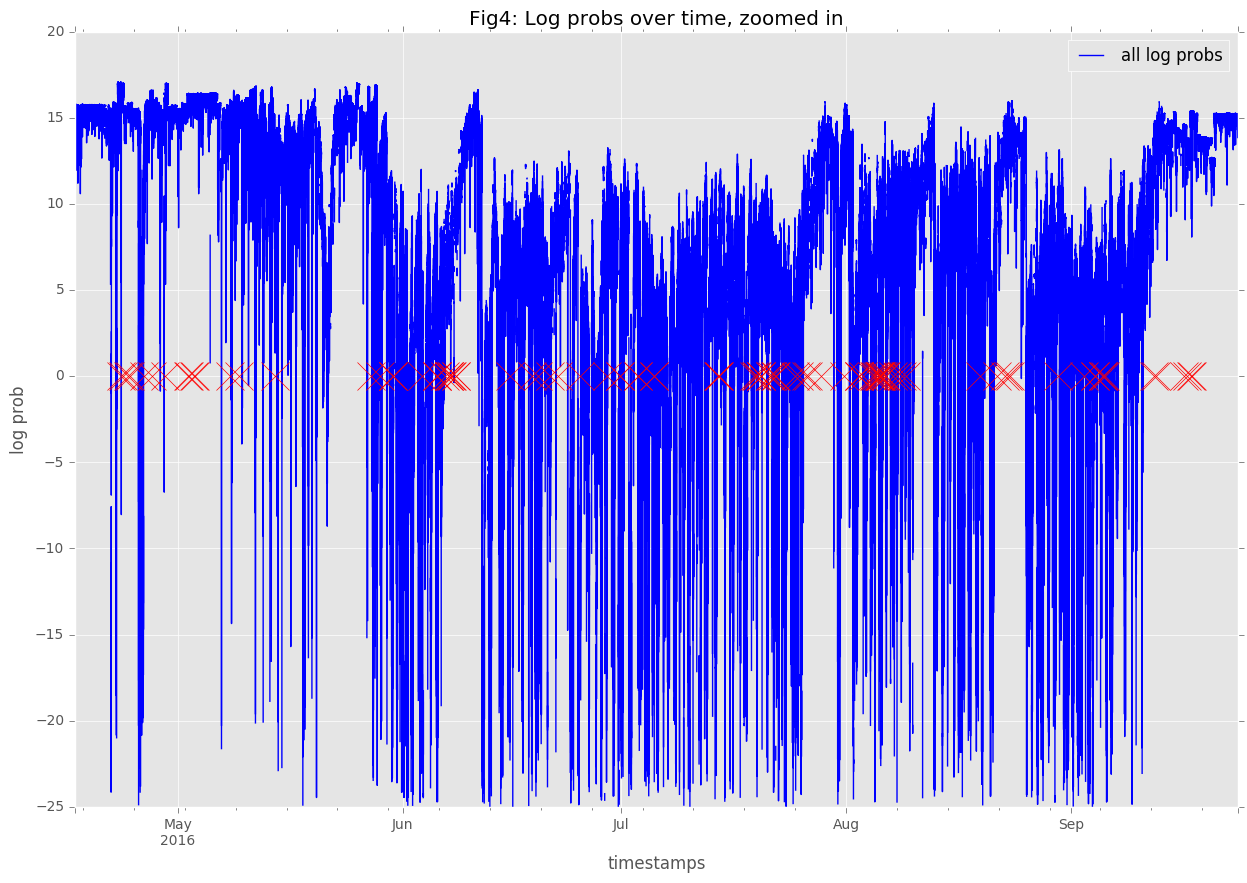

In [68]:
log_probs_df2 = log_probs_df[log_probs_df>-25]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df2.plot(ax=axes, color='b')
df_elogbook.plot(ax=axes, y='marker', linestyle='none', marker='x', markersize=20, color='red')
labels = ["all log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig4: Log probs over time, zoomed in")

Markers don't seem to directly correspond with possible anomalies.
Interesting: many markers first quarter of August.

In [69]:
display(df_elogbook['2016-8-1':'2016-8-15'])
df_elogbook.loc['2016-08-05 07:29:20', "MKI.ELOGBOOK"][0]

series                                                    MKI.ELOGBOOK  marker
timestamps                                                                    
2016-08-02 17:28:00  {u'USERNAME': u'christophe.lolliot@cern.ch', u...       0
2016-08-02 17:50:00  {u'USERNAME': u'christophe.lolliot@cern.ch', u...       0
2016-08-02 19:53:00  {u'USERNAME': u'christophe.lolliot@cern.ch', u...       0
2016-08-03 08:05:00  {u'USERNAME': u'christophe.lolliot@cern.ch', u...       0
2016-08-04 14:03:41  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21564...       0
2016-08-04 20:37:49  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21567...       0
2016-08-04 22:21:09  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21567...       0
2016-08-05 07:29:20  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21568...       0
2016-08-05 13:03:07  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21570...       0
2016-08-05 14:09:02  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21570...       0
2016-08-05 15:19:18  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21571...       0
2016-08-05 16:42:30  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21571...       0
2016-08-05 19:10:15  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21572...       0
2016-08-05 20:13:52  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21573...       0
2016-08-06 01:17:53  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21574...       0
2016-08-06 10:11:31  {u'USERNAME': u'lhcop', u'EVENT_ID': u'2157588...       0
2016-08-06 11:22:33  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21576...       0
2016-08-07 10:44:07  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21579...       0
2016-08-07 22:46:55  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21582...       0
2016-08-08 16:00:38  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21586...       0
2016-08-09 06:22:26  {u'USERNAME': u'tkramer', u'EVENT_ID': u'21589...       0

{u'C0': u'72',
 u'EVENTDATE': u'05/08/2016 09:29:20',
 u'EVENT_ID': u'2156897',
 u'PATH': u'LHC.MKI2',
 u'SUBSTR_COMMENT_512_': u'Asked OP (J\xf6rg, Matteo) to move the intermediate softstart further away from the beginning of the ramp down sequence. Currently the softstart is executed ~1-2min after the dump which is still in the decay of the higher vacuum level after operation with beam.',
 u'TAG': u'KEY',
 u'USERNAME': u'tkramer',
 u'VALUE': u'MKI2'}

In [74]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

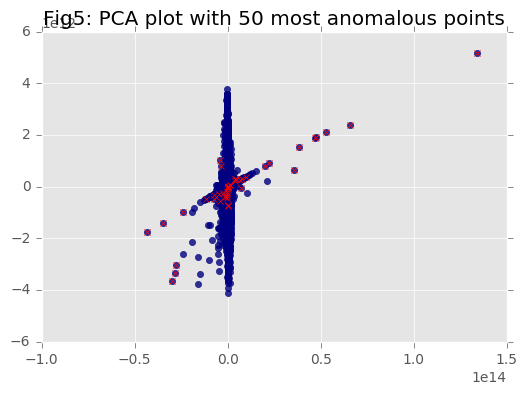

In [75]:
PCA.plot_anomalies(pca_data, top50, "Fig5: PCA plot with 50 most anomalous points")

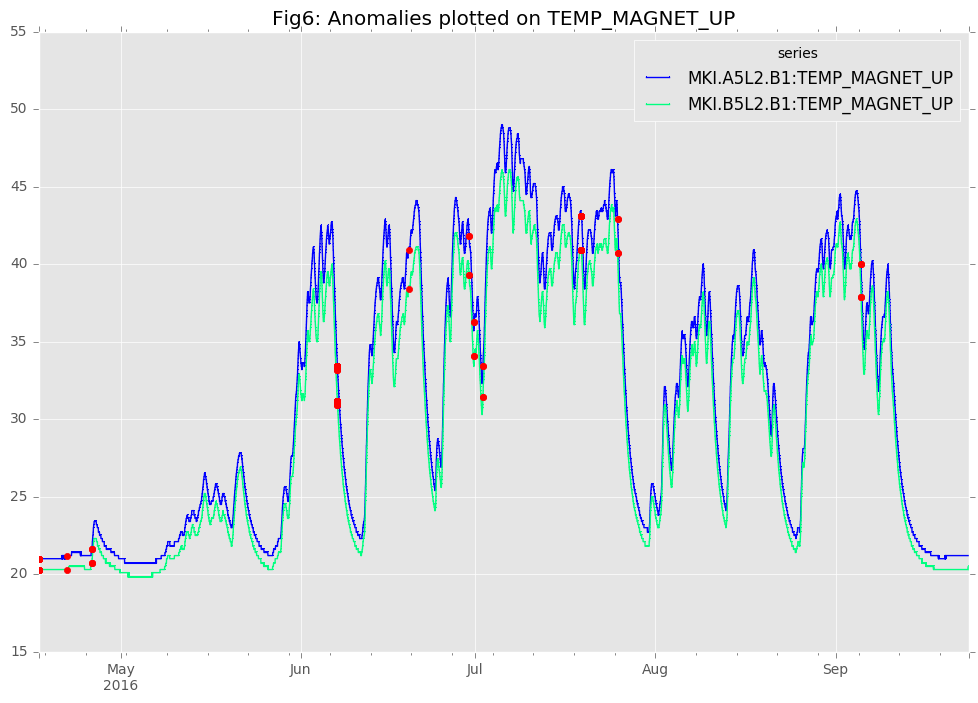

In [76]:
results.plot_anomalies_timeseries(df, top50, "TEMP_MAGNET_UP", "Fig6: Anomalies plotted on TEMP_MAGNET_UP")

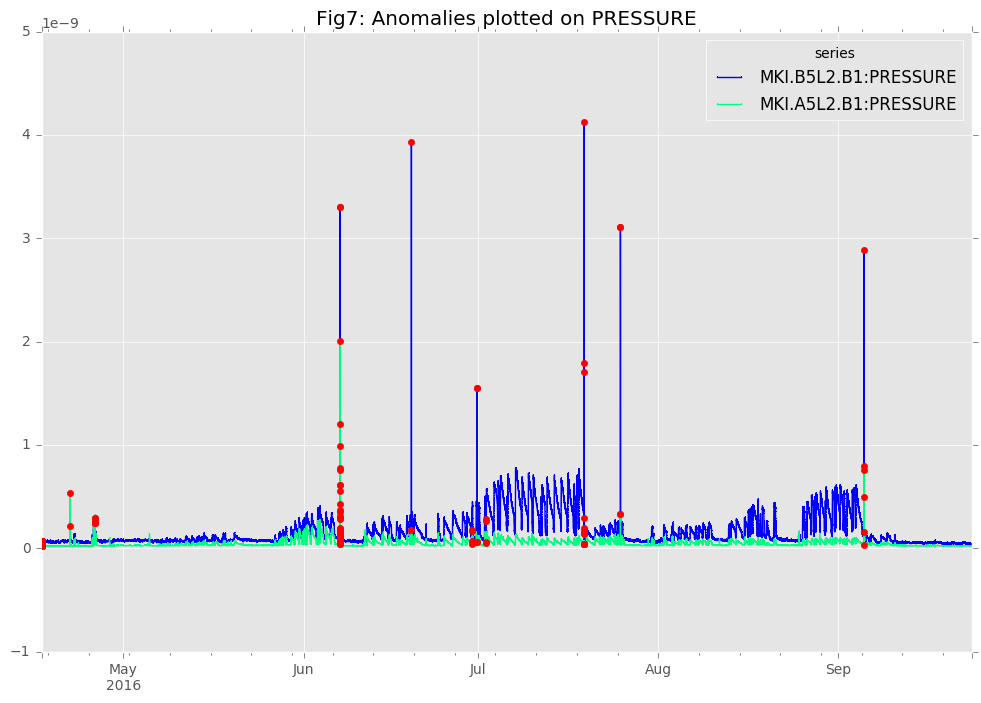

In [77]:
results.plot_anomalies_timeseries(df, top50, "PRESSURE", "Fig7: Anomalies plotted on PRESSURE")